<a href="https://colab.research.google.com/github/karinaAlex/graph_climate/blob/main/graph_climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи
Цель проекта:
 	Исследовать структуру температурных взаимосвязей между семью городами России (Москва, Санкт-Петербург, Нижний Новгород, Казань, Уфа, Новосибирск, Владивосток) в течение 2023 года с использованием сетевого анализа на основе коэффициентов корреляции Кендалла и Пирсона.
Задачи:
### 1. Сбор и подготовка данных
Получить температурные данные за 2023 год для указанных городов. Рассмотреть три различных режима наблюдения: раз в час, раз в день, раз в месяц. Проанализировать данные.
### 2. Построение сетей случайных величин
Для каждого режима наблюдения и каждого времени года (зима, весна, лето, осень) построить сетевые модели на основе коэффициентов корреляции Кендалла и Пирсона (всего 24 модели: 3 режима × 4 сезона × 2 метода корреляции)
### 3. Построение отсеченных графов
Для каждой из сетевых моделей построить отсеченные графы по заданной последовательности порогов значений корреляции. Для этих графов определить: клики, независимые множества.
### 4. Сравнительный анализ
Сравнить полученные клики и независимые множества между разными временами года и режимами наблюдения.
Проверить гипотезу о том, что структура температурной связи между городами остается неизменной вне зависимости от времени года и частоты наблюдений.


# Сбор и предобработка данных

Источник данных:
Всероссийский научно-исследовательский институт гидрометеорологической информации – Мировой центр данных Федеральная служба по гидрометеорологии и мониторингу окружающей среды

Ссылка: http://meteo.ru/data/


1) Булыгина О.Н., Разуваев В.Н., Александрова Т.М.
«Описание массива данных суточной температуры воздуха и количества осадков на метеорологических станциях России и бывшего СССР (TTTR)».

Ссылка: http://meteo.ru/data/temperature-precipitation/

2) Булыгина О.Н., Веселов В.М., Разуваев В.Н., Александрова Т.М.
«Описание массива срочных данных об основных метеорологических параметрах на станциях России».

Ссылка: http://meteo.ru/data/basic-parameters/


## Импорты

In [ ]:
pip install pyvis

In [54]:
import pandas as pd
import numpy as np
import json
import os

import networkx as nx
from pyvis.network import Network

import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette('deep')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

## Предобработка данных

### По дням

In [7]:
header_list = ['index_vmo', 'year', 'month', 'day', 'tflag', 'tmin', 'qtmin', 'tmean', 'qtmean', 'tmax', 'qtmax', 'r', 'cr', 'qr']

data = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/Colab Notebooks/Твой проект ВШЭ 2025/meteo_data/daily_temp_data.txt',
    sep=';',
    encoding='windows-1251',
    header=0,
    names=header_list
                   )

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index_vmo  7305 non-null   int64 
 1   year       7305 non-null   int64 
 2   month      7305 non-null   int64 
 3   day        7305 non-null   int64 
 4   tflag      7305 non-null   int64 
 5   tmin       7305 non-null   object
 6   qtmin      7305 non-null   int64 
 7   tmean      7305 non-null   object
 8   qtmean     7305 non-null   int64 
 9   tmax       7305 non-null   object
 10  qtmax      7305 non-null   int64 
 11  r          7305 non-null   object
 12  cr         7305 non-null   int64 
 13  qr         7305 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 799.1+ KB


In [9]:
df = data.copy()

# отбираем нужный год
df = data[data['year']==2023]

# отбираем атрибуты
df = df[['index_vmo', 'year', 'month', 'day', 'tflag', 'tmin', 'tmean', 'tmax']]

# преобразуем типы данных
df['tmin'] = pd.to_numeric(df['tmin'], errors='raise')
df['tmean'] = pd.to_numeric(df['tmean'], errors='raise')
df['tmax'] = pd.to_numeric(df['tmax'], errors='raise')

In [10]:
# добавим наименования городов нахождения метеостанций
index_vmo_to_city = {
    29638 :'Новосибирск',
    27612 :'Москва',
    26063 :'Санкт-Петербург',
    27595 :'Казань',
    27459 :'Нижний-Новгород',
    28722 :'Уфа',
    31960 :'Владивосток'
}

df['city'] = df['index_vmo'].map(index_vmo_to_city)

In [11]:
# добавим колонку с датой
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [12]:
# согласно флагу tflag - все значения к таблице соотвествуют требованиям качества для характеристик температуры воздуха
# далее исключим данный параметр из датасета
print(df.tflag.value_counts())

tflag
0    2555
Name: count, dtype: int64


In [13]:
# определим порядок колонок и исключим tflag
df_days = df[['index_vmo', 'city', 'date',  'tmin', 'tmean', 'tmax']]

In [14]:
df_days.sample(5)

,index_vmo,city,date,tmin,tmean,tmax
2737,27459,Нижний-Новгород,2023-07-01,12.2,16.2,19.9
2865,27459,Нижний-Новгород,2023-11-06,5.6,7.6,9.2
5481,29638,Новосибирск,2023-01-04,-6.0,-3.6,-1.5
2589,27459,Нижний-Новгород,2023-02-03,-5.0,-3.7,-2.8
600,27612,Москва,2023-08-25,8.5,13.9,19.5


In [15]:
df_days.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2555 entries, 364 to 6938
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index_vmo  2555 non-null   int64         
 1   city       2555 non-null   object        
 2   date       2555 non-null   datetime64[ns]
 3   tmin       2555 non-null   float64       
 4   tmean      2555 non-null   float64       
 5   tmax       2555 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 139.7+ KB


In [16]:
df_days[['tmin', 'tmean', 'tmax']].describe()

,tmin,tmean,tmax
count,2555.000000,2555.000000,2555.000000
mean,2.268767,6.178160,10.466849
std,11.343805,11.879754,12.801319
min,-39.200000,-35.600000,-31.800000
25%,-4.950000,-2.300000,0.200000
50%,3.300000,7.200000,11.900000
75%,11.150000,16.200000,21.500000
max,24.000000,28.800000,39.400000


In [17]:
df_days = df_days.rename(columns={'tmean':'temp'})
df_days = df_days[['city', 'date', 'temp']]

In [18]:
df_days

,city,date,temp
364,Москва,2023-01-01,2.6
365,Москва,2023-01-02,1.1
366,Москва,2023-01-03,-0.5
367,Москва,2023-01-04,-2.1
368,Москва,2023-01-05,-5.8
...,...,...,...
6934,Владивосток,2023-12-27,-9.4
6935,Владивосток,2023-12-28,-6.8
6936,Владивосток,2023-12-29,-5.2
6937,Владивосток,2023-12-30,-5.1


### По месяцам

In [19]:
header_list = ['index_vmo', 'year', 'january', 'february', 'march', 'april', 'may',
               'june', 'july', 'august', 'september', 'october', 'november', 'december']

data_month = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/Colab Notebooks/Твой проект ВШЭ 2025/meteo_data/months_data.txt',
    sep=';',
    encoding='windows-1251',
    header=0,
    names=header_list
                   )

In [20]:
# данные неполные
data_month.year.value_counts()

,count
year,
2023,7
2022,6


In [21]:
# сделаем свои из данных по дням
df_month = df.copy()
df_month['month'] = df_month['date'].dt.month

In [22]:
df_month = df_month.groupby(['index_vmo', 'city', 'month'])[['tmin', 'tmean', 'tmax']].mean().reset_index()


In [23]:
df_month = df_month.rename(columns={'month': 'date', 'tmean': 'temp'})

df_month = df_month[['city', 'date', 'temp']]

In [24]:
df_month.sample(5)

,city,date,temp
40,Москва,5,12.725806
74,Владивосток,3,1.525806
48,Уфа,1,-14.951613
54,Уфа,7,21.664516
2,Санкт-Петербург,3,-0.341935


### По часам

In [25]:
header_list = [ 'Синоптический индекс станции', 'Год по Гринвичу', 'Месяц по Гринвичу', 'День по Гринвичу', 'Срок по Гринвичу',
 'Год источника (местный)', 'Месяц источника (местный)', 'День  источника (местный)', 'Срок  источника (местный)',
 'Номер срока в сутках по ПДЗВ', 'Время местное', 'Номер часового пояса', 'Начало метеорологических суток по ПДЗВ',
 'Погода между сроками', 'Признак качества 1', 'Температура поверхности почвы', 'Признак качества 2', 'Температура пов. почвы по мин. терм-ру',
 'Признак качества 3', 'Мин. температура пов-сти почвы между сроками', 'Признак качества 4', 'Макс. температура пов-сти почвы между сроками',
 'Признак качества 5', 'Температура пов-сти почвы по макс. терм-ру п/встр.', 'Признак качества 6', 'Температура воздуха по сухому терм-ру',
 'Признак качества 7', 'Темп.воздуха по смоченному терм-ру', 'Признак качества 8', 'Признак нал. льда на батисте', 'Температура воздуха по мин. терм-ру',
 'Признак качества 9', 'Мин.температура воздуха между сроками', 'Признак качества 10', 'Макс. темперура воздуха между сроками', 'Признак качества 11',
 'Темпера воздуха по макс. терм-ру после встрях.', 'Признак качества 12']

data = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/Colab Notebooks/Твой проект ВШЭ 2025/meteo_data/hours_data.txt',
    sep=';',
    encoding='windows-1251',
    header=0,
    names=header_list
                   )

In [26]:
df = data.copy()
df = df[['Синоптический индекс станции',
             'Год источника (местный)', 'Месяц источника (местный)',
             'День  источника (местный)',
             'Время местное',
             'Температура воздуха по сухому терм-ру'
             ]]

df = df.rename(columns={
    'Синоптический индекс станции' : 'index_vmo',
    'Год источника (местный)': 'year',
    'Месяц источника (местный)': 'month',
    'День  источника (местный)': 'day',
    'Время местное': 'local_time',
    'Температура воздуха по сухому терм-ру': 'temp'
})

df = df[(df['year']==2023)]

In [27]:
df.sort_values(['index_vmo'])[:10]

,index_vmo,year,month,day,local_time,temp
11716,26063,2023,1,4,21,-8.0
11715,26063,2023,1,4,18,-5.3
11714,26063,2023,1,4,15,-3.6
11713,26063,2023,1,4,12,-3.5
11712,26063,2023,1,4,9,-3.2
11711,26063,2023,1,4,6,-2.7
11710,26063,2023,1,4,3,-2.6
11709,26063,2023,1,4,0,-1.8
11708,26063,2023,1,3,21,-1.8
11707,26063,2023,1,3,18,-1.4


In [28]:
# проверка на нуллы
df['temp'].astype('float').isna().value_counts()

,count
temp,
False,20440


In [30]:
# добавим наименования городов нахождения метеостанций
index_vmo_to_city = {
    29638 :'Новосибирск',
    27612 :'Москва',
    26063 :'Санкт-Петербург',
    27595 :'Казань',
    27459 :'Нижний-Новгород',
    28722 :'Уфа',
    31960 :'Владивосток'
}

df['city'] = df['index_vmo'].map(index_vmo_to_city)

In [31]:
# добавим дату
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [32]:
# изменение типа данных температуры
df['temp'] = df['temp'].astype('float')

In [33]:
# сортировка
df = (
    df[['index_vmo', 'city', 'date', 'local_time', 'temp']]
    .sort_values(['index_vmo', 'date', 'local_time'])
    .reset_index(drop=True)
)

In [34]:
df_hours = df.copy()

In [35]:
df_hours.city.value_counts()

,count
city,
Санкт-Петербург,2920
Нижний-Новгород,2920
Казань,2920
Москва,2920
Уфа,2920
Новосибирск,2920
Владивосток,2920


In [36]:
# сместим данные чтобы часы совпадали
list1 = ['Владивосток', 'Казань', 'Нижний-Новгород', 'Новосибирск']
list2 = ['Уфа']

df_hours.loc[df['city'].isin(list1), 'local_time'] = df_hours['local_time'] - 1
df_hours.loc[df['city'].isin(list2), 'local_time'] = df_hours['local_time'] - 2

In [37]:
df_hours['date'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['local_time'], unit='h')

df_hours = df_hours[['city', 'date', 'temp']]

In [39]:
df_hours

,city,date,temp
0,Санкт-Петербург,2023-01-01 00:00:00,3.9
1,Санкт-Петербург,2023-01-01 03:00:00,3.9
2,Санкт-Петербург,2023-01-01 06:00:00,4.1
3,Санкт-Петербург,2023-01-01 09:00:00,3.4
4,Санкт-Петербург,2023-01-01 12:00:00,2.4
...,...,...,...
20435,Владивосток,2023-12-31 10:00:00,-14.0
20436,Владивосток,2023-12-31 13:00:00,-12.8
20437,Владивосток,2023-12-31 16:00:00,-12.0
20438,Владивосток,2023-12-31 19:00:00,-13.5


# Подготовка данных

После предобработки сырых данных мы получили три датасета с температурными данными по месяцам, дням и часам. Далее необходимо разделить данные по сезонам и подготовить формат для построения матриц корреляции.

### Примеры предобработанных данных

In [40]:
df_days.sample(5)

,city,date,temp
425,Москва,2023-03-03,0.0
3590,Казань,2023-11-01,4.3
6680,Владивосток,2023-04-17,6.0
596,Москва,2023-08-21,17.3
3513,Казань,2023-08-16,21.8


In [41]:
df_month.sample(5)

,city,date,temp
13,Нижний-Новгород,2,-6.357143
36,Москва,1,-4.654839
66,Новосибирск,7,21.577419
60,Новосибирск,1,-12.793548
65,Новосибирск,6,18.970000


In [42]:
df_hours.sample(5)

,city,date,temp
8526,Казань,2023-12-02 19:00:00,-4.9
3483,Нижний-Новгород,2023-03-12 10:00:00,2.4
3618,Нижний-Новгород,2023-03-29 07:00:00,-0.7
14413,Уфа,2023-12-08 17:00:00,-25.3
7274,Казань,2023-06-29 07:00:00,18.7


## Графики

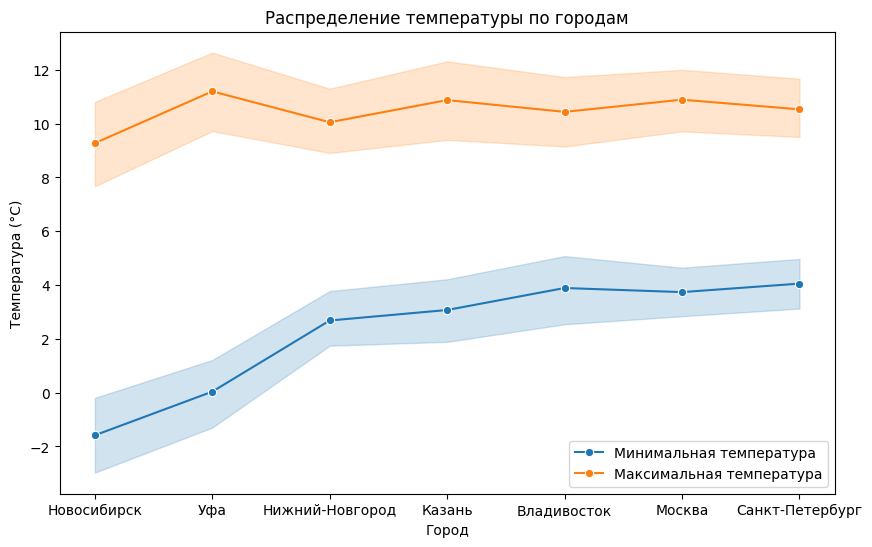

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='city', y='tmin', label='Минимальная температура', marker='o', data=df.sort_values('tmax'))
sns.lineplot(x='city', y='tmax', label='Максимальная температура', marker='o', data=df.sort_values('tmax'))
plt.title('Распределение температуры по городам')
plt.xlabel('Город')
plt.ylabel('Температура (°C)')
plt.legend()
plt.show()

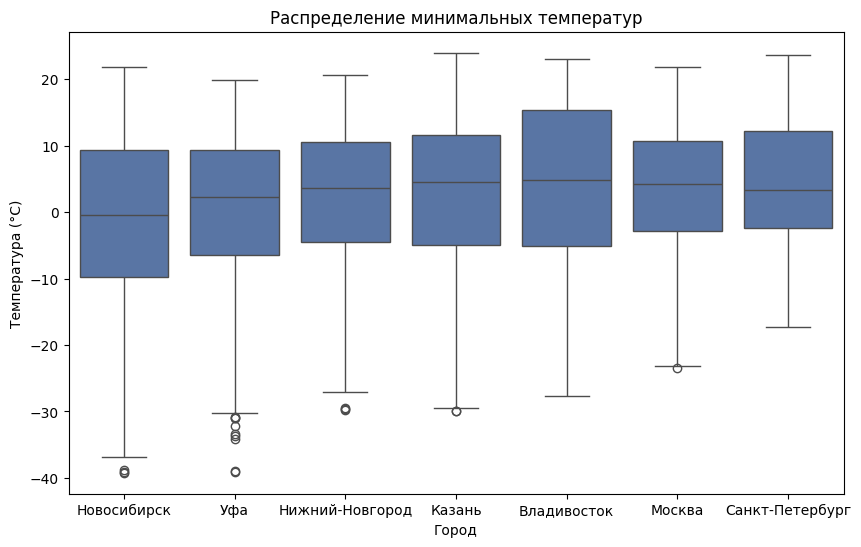

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='city', y='tmin', color=palette[0], data=df.sort_values('tmax'))
plt.title('Распределение минимальных температур')
plt.xlabel('Город')
plt.ylabel('Температура (°C)')
plt.show()

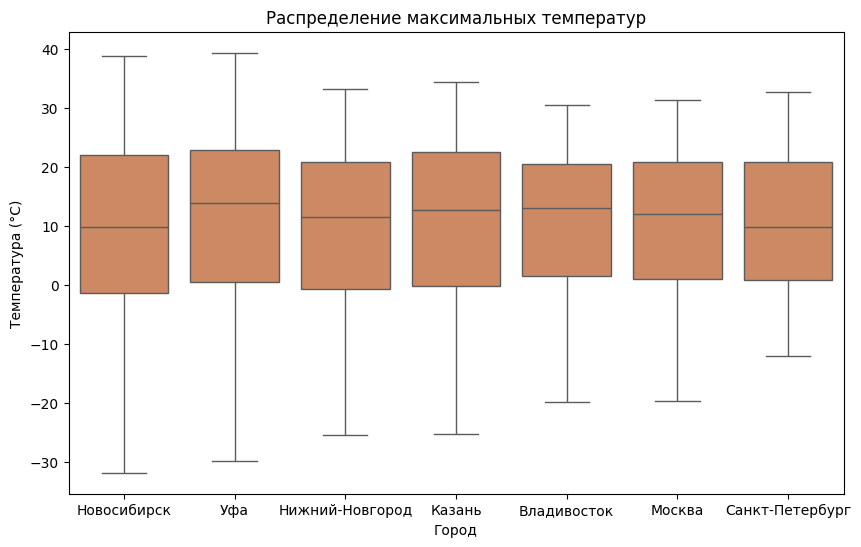

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='city', y='tmax', color=palette[1], data=df.sort_values('tmax'))
plt.title('Распределение максимальных температур')
plt.xlabel('Город')
plt.ylabel('Температура (°C)')
plt.show()

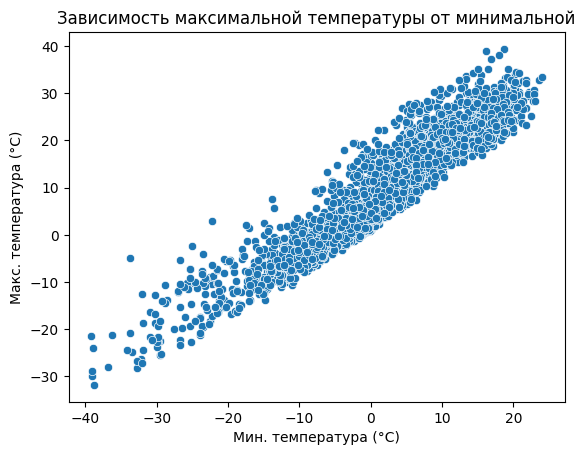

In [ ]:
sns.scatterplot(x='tmin', y='tmax', data=df,
                # hue='city'
                )
plt.title('Зависимость максимальной температуры от минимальной')
plt.xlabel('Мин. температура (°C)')
plt.ylabel('Макс. температура (°C)')
plt.show()

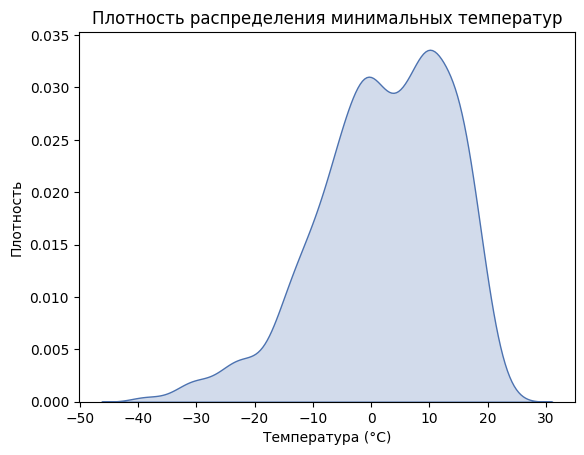

In [ ]:
sns.kdeplot(df['tmin'], fill=True, color=palette[0])
plt.title('Плотность распределения минимальных температур')
plt.xlabel('Температура (°C)')
plt.ylabel('Плотность')
plt.show()

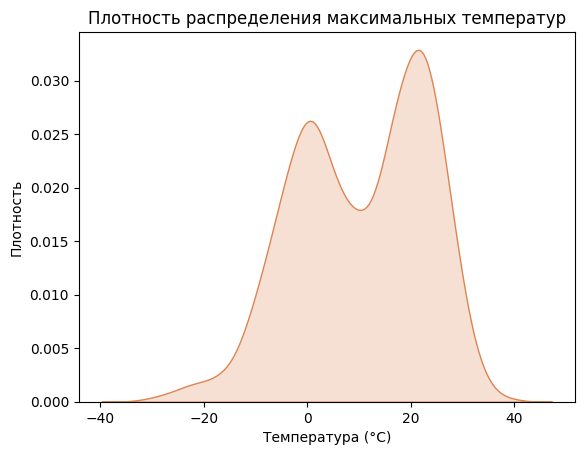

In [ ]:
sns.kdeplot(df['tmax'], fill=True, color=palette[1])
plt.title('Плотность распределения максимальных температур')
plt.xlabel('Температура (°C)')
plt.ylabel('Плотность')
plt.show()

## Разделение датасетов по сезонам

In [43]:
season_dict = {
    12: "winter", 1: "winter", 2: "winter",
    3: "spring", 4: "spring", 5: "spring",
    6: "summer", 7: "summer", 8: "summer",
    9: "autumn", 10: "autumn", 11: "autumn"
}

# Добавляем столбец с сезоном
df_hours["season"] = df_hours["date"].dt.month.map(season_dict)
df_days["season"] = df_days["date"].dt.month.map(season_dict)
df_month["season"] = df_month["date"].map(season_dict)

In [44]:
# Разделение на сезоны
seasons_hours = df_hours.groupby("season")
seasons_days = df_days.groupby("season")
seasons_month = df_month.groupby("season")

winter_data_hours = seasons_hours.get_group("winter")
spring_data_hours = seasons_hours.get_group("spring")
summer_data_hours = seasons_hours.get_group("summer")
autumn_data_hours = seasons_hours.get_group("autumn")

winter_data_days = seasons_days.get_group("winter")
spring_data_days = seasons_days.get_group("spring")
summer_data_days = seasons_days.get_group("summer")
autumn_data_days = seasons_days.get_group("autumn")

winter_data_months = seasons_month.get_group("winter")
spring_data_months = seasons_month.get_group("spring")
summer_data_months = seasons_month.get_group("summer")
autumn_data_months = seasons_month.get_group("autumn")

## Изменение формата таблиц

In [45]:
winter_data_hours_pivot = winter_data_hours.pivot(index='date', columns='city', values='temp')
spring_data_hours_pivot = spring_data_hours.pivot(index='date', columns='city', values='temp')
summer_data_hours_pivot = summer_data_hours.pivot(index='date', columns='city', values='temp')
autumn_data_hours_pivot = autumn_data_hours.pivot(index='date', columns='city', values='temp')

winter_data_days_pivot = winter_data_days.pivot(index='date', columns='city', values='temp')
spring_data_days_pivot = spring_data_days.pivot(index='date', columns='city', values='temp')
summer_data_days_pivot = summer_data_days.pivot(index='date', columns='city', values='temp')
autumn_data_days_pivot = autumn_data_days.pivot(index='date', columns='city', values='temp')

winter_data_months_pivot = winter_data_months.pivot(index='date', columns='city', values='temp')
spring_data_months_pivot = spring_data_months.pivot(index='date', columns='city', values='temp')
summer_data_months_pivot = summer_data_months.pivot(index='date', columns='city', values='temp')
autumn_data_months_pivot = autumn_data_months.pivot(index='date', columns='city', values='temp')

## Примеры обработанных данных

In [46]:
winter_data_hours_pivot.sample(5)

city,Владивосток,Казань,Москва,Нижний-Новгород,Новосибирск,Санкт-Петербург,Уфа
date,,,,,,,
2023-02-10 19:00:00,-4.2,-5.0,NaN,-4.0,-26.5,NaN,NaN
2023-12-12 22:00:00,-13.5,-17.8,NaN,-11.8,-27.5,NaN,NaN
2023-01-02 03:00:00,NaN,NaN,2.6,NaN,NaN,-1.0,NaN
2023-01-07 04:00:00,-12.6,-28.0,NaN,-27.4,-17.5,NaN,NaN
2023-12-25 01:00:00,-7.7,-2.0,NaN,-1.3,-10.4,NaN,NaN


In [47]:
spring_data_days_pivot.sample(5)

city,Владивосток,Казань,Москва,Нижний-Новгород,Новосибирск,Санкт-Петербург,Уфа
date,,,,,,,
2023-04-14,7.7,2.3,5.6,2.4,1.1,4.3,3.6
2023-04-09,4.2,6.6,9.4,7.4,-2.4,6.8,3.6
2023-04-12,5.6,10.4,11.2,10.8,-0.9,10.3,7.1
2023-05-21,11.5,19.8,13.2,15.5,17.0,15.7,15.9
2023-03-04,-1.5,-1.5,-0.9,-1.0,-6.2,-0.4,-2.9


In [48]:
autumn_data_months_pivot

city,Владивосток,Казань,Москва,Нижний-Новгород,Новосибирск,Санкт-Петербург,Уфа
date,,,,,,,
9,18.470000,15.540000,15.036667,14.190000,11.820000,16.430000,13.456667
10,11.109677,5.787097,5.483871,4.551613,5.635484,4.970968,5.583871
11,-1.160000,0.250000,0.766667,-0.070000,-2.393333,0.100000,0.633333


# Построение сетей случайных величин и отсеченных графов

In [49]:
pivot_df_list = [winter_data_hours_pivot,
                spring_data_hours_pivot,
                summer_data_hours_pivot,
                autumn_data_hours_pivot,
                winter_data_days_pivot,
                spring_data_days_pivot,
                summer_data_days_pivot,
                autumn_data_days_pivot,
                winter_data_months_pivot,
                spring_data_months_pivot,
                summer_data_months_pivot,
                autumn_data_months_pivot]

pivot_df_names_list = ['winter_hours', 'spring_hours', 'summer_hours', 'autumn_hours',
                       'winter_days', 'spring_days', 'summer_days', 'autumn_days',
                       'winter_months', 'spring_months', 'summer_months', 'autumn_months']

# создадим словарь по которому будем итерироваться
df_dict = dict(zip(pivot_df_names_list, pivot_df_list))

In [50]:
def build_graph_and_analyze(df, method='pearson', threshold=0.7):
    corr = df.corr(method=method)
    G = nx.Graph()

    for col in corr.columns:
        G.add_node(col)

    for i in corr.columns:
        for j in corr.columns:
            if i < j and abs(corr.loc[i, j]) >= threshold:
                G.add_edge(i, j, weight=corr.loc[i, j])

    cliques = list(nx.find_cliques(G))
    max_clique = max(cliques, key=len) if cliques else []
    independent_sets = list(nx.maximal_independent_set(G, seed=42))
    return {
        "graph": G,
        "clique_size": len(max_clique),
        "clique": max_clique,
        "independent_set_size": len(independent_sets),
        "independent_set": independent_sets
    }

In [55]:
results = []

# варианты трешхолдов
for threshold in [0.3, 0.5, 0.7, 0.9]:
    # методы
    for method in ['pearson', 'kendall']:
        # проходимя по каждому датасету
        for name, df in df_dict.items():
            season, _, frequency = name.partition('_')

            res = build_graph_and_analyze(df, method='kendall', threshold=threshold)
            results.append({
                "threshold": threshold,
                "method": method,
                "frequency": frequency,
                "season": season,
                "clique_size": res["clique_size"],
                "clique": res["clique"],
                "indep_set_size": res["independent_set_size"],
                "indep_set": res["independent_set"]
            })

# создаем датафрейм с результатами
results_df = pd.DataFrame(results)
results_df.sort_values(by=["method", "frequency", "season", "threshold"]).head()

,threshold,method,frequency,season,clique_size,clique,indep_set_size,indep_set
19,0.3,kendall,days,autumn,7,"[Москва, Санкт-Петербург, Нижний-Новгород, Казань, Владивосток, Новосибирск, Уфа]",1,[Санкт-Петербург]
43,0.5,kendall,days,autumn,6,"[Санкт-Петербург, Казань, Владивосток, Москва, Нижний-Новгород, Уфа]",1,[Санкт-Петербург]
67,0.7,kendall,days,autumn,4,"[Нижний-Новгород, Казань, Москва, Санкт-Петербург]",4,"[Санкт-Петербург, Владивосток, Новосибирск, Уфа]"
91,0.9,kendall,days,autumn,1,[Москва],7,"[Санкт-Петербург, Москва, Нижний-Новгород, Владивосток, Казань, Новосибирск, Уфа]"
17,0.3,kendall,days,spring,7,"[Москва, Санкт-Петербург, Нижний-Новгород, Казань, Владивосток, Новосибирск, Уфа]",1,[Санкт-Петербург]


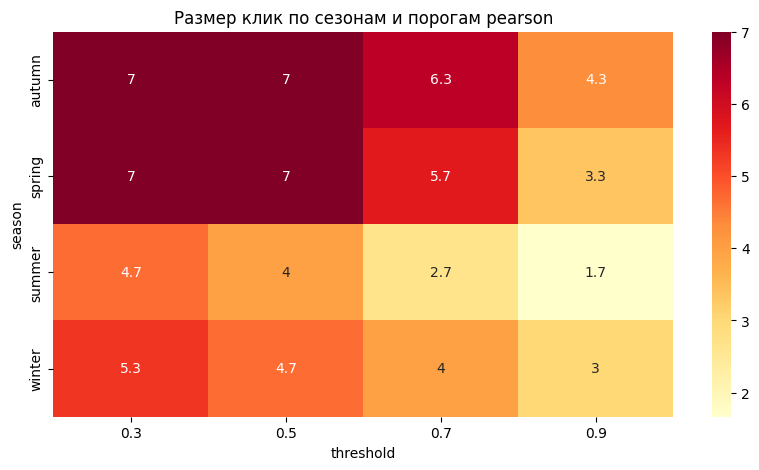

In [ ]:
# Сводная таблица
heatmap_data = results_df_pearson.pivot_table(index='season', columns='threshold', values='clique_size', aggfunc='mean')

# Рисуем тепловую карту
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data, annot=True, cmap="YlOrRd")
plt.title("Размер клик по сезонам и порогам pearson")
plt.show()

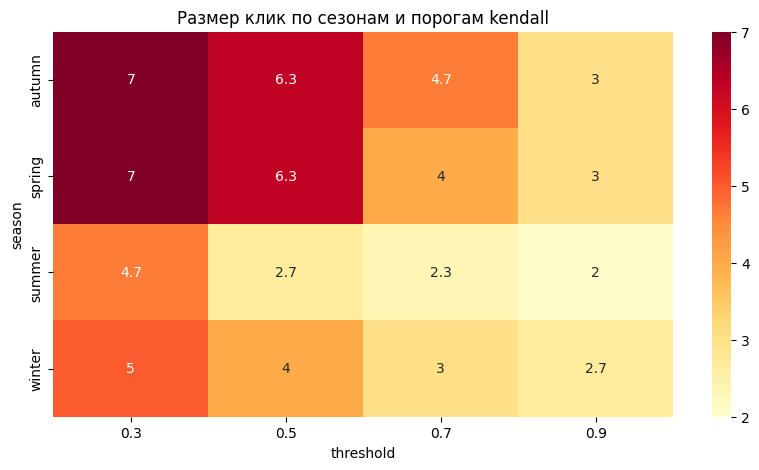

In [ ]:
# Сводная таблица
heatmap_data = results_df_kendall.pivot_table(index='season', columns='threshold', values='clique_size', aggfunc='mean')

# Рисуем тепловую карту
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data, annot=True, cmap="YlOrRd")
plt.title("Размер клик по сезонам и порогам kendall")
plt.show()

# Интерактивные графики

## Network

In [56]:
def build_interactive_graphs(df, method='pearson', season_freq=None,
                             thresholds=[0.5, 0.7], output_dir='graph_outputs'):

    os.makedirs(output_dir, exist_ok=True)
    corr = df.corr(method=method)

    for threshold in thresholds:
        net = Network(
            height='900px',
            width='1200px',
            notebook=True,
            font_color='black',
            bgcolor='white'
        )
        net.barnes_hut()

        # Узлы
        node_options = {
            'size': 15,
            'font': {
                'size': 10,
                'face': 'arial',
                'strokeWidth': 0
            },
            'borderWidth': 1,
            'color': {
                'border': '#2B7CE9',
                'background': '#97C2FC',
                'highlight': {
                    'border': '#FFA500',
                    'background': '#FFFF00'
                },
                'hover': {
                    'border': '#FF0000',
                    'background': '#FFD700'
                }
            },
            'physics': True
        }

        # Рёбра
        edge_options = {
            'smooth': {
                'type': 'continuous',
                'roundness': 0.5
            },
            'width': 1.2,
            'font': {
                'size': 10,
                'align': 'middle',
                'strokeWidth': 0
            },
            'color': {
                'color': '#848484',
                'highlight': '#FF69B4',
                'hover': '#FF1493'
            },
            'selectionWidth': 1.5,
            'hoverWidth': 1.5,
            'physics': True
        }

        # Узлы
        for col in corr.columns:
            net.add_node(col, label=col, **node_options)

        # Рёбра
        for i in corr.columns:
            for j in corr.columns:
                if i < j:
                    val = corr.loc[i, j]
                    if abs(val) >= threshold:
                        base_color = '#FF0000' if val < 0 else '#009900'
                        edge_options['color']['color'] = base_color
                        edge_options['color']['highlight'] = '#FFA500'
                        edge_options['color']['hover'] = '#FF4500'

                        net.add_edge(
                            i, j,
                            value=abs(val)*4,
                            title=f"{val:.2f}",
                            label=f"{val:.2f}",
                            **edge_options
                        )

        # Настройки физики
        net.set_options("""
        {
            "physics": {
                "barnesHut": {
                    "gravitationalConstant": -8000,
                    "centralGravity": 0.05,
                    "springLength": 400,
                    "springConstant": 0.005,
                    "damping": 0.3,
                    "avoidOverlap": 1
                },
                "minVelocity": 0.75,
                "solver": "barnesHut"
            },
            "interaction": {
                "hover": true,
                "tooltipDelay": 100,
                "hideEdgesOnDrag": true,
                "multiselect": true
            },
            "nodes": {
                "scaling": {
                    "min": 10,
                    "max": 20
                }
            }
        }
        """)

        filename = f"{method}_thresh_{threshold}_{season_freq}.html"
        net.show(os.path.join(output_dir, filename))
        print(f"Граф сохранён: {filename}")

In [57]:
pivot_df_list = [winter_data_hours_pivot,
                spring_data_hours_pivot,
                summer_data_hours_pivot,
                autumn_data_hours_pivot,
                winter_data_days_pivot,
                spring_data_days_pivot,
                summer_data_days_pivot,
                autumn_data_days_pivot,
                winter_data_months_pivot,
                spring_data_months_pivot,
                summer_data_months_pivot,
                autumn_data_months_pivot]

pivot_df_names_list = ['winter_hours', 'spring_hours', 'summer_hours', 'autumn_hours',
                       'winter_days', 'spring_days', 'summer_days', 'autumn_days',
                       'winter_months', 'spring_months', 'summer_months', 'autumn_months']


df_dict = dict(zip(pivot_df_names_list, pivot_df_list))

In [ ]:
# строим графы метод Пирсон
for names, dfs in df_dict.items():
  build_interactive_graphs(dfs, method='pearson', season_freq=names)

In [ ]:
# строим графы метод Кендалл
for names, dfs in df_dict.items():
  build_interactive_graphs(dfs, method='kendall', season_freq=names)

In [ ]:
# зазипуем данные для последующей выгрузки
!zip -r graph_outputs.zip graph_outputs/

  adding: graph_outputs/ (stored 0%)
  adding: graph_outputs/kendall_thresh_0.5_autumn_hours.html (deflated 83%)
  adding: graph_outputs/pearson_thresh_0.7_summer_days.html (deflated 75%)
  adding: graph_outputs/pearson_thresh_0.7_winter_hours.html (deflated 77%)
  adding: graph_outputs/pearson_thresh_0.5_autumn_hours.html (deflated 85%)
  adding: graph_outputs/pearson_thresh_0.5_autumn_days.html (deflated 85%)
  adding: graph_outputs/kendall_thresh_0.5_winter_months.html (deflated 85%)
  adding: graph_outputs/kendall_thresh_0.5_spring_months.html (deflated 87%)
  adding: graph_outputs/pearson_thresh_0.7_spring_months.html (deflated 85%)
  adding: graph_outputs/kendall_thresh_0.7_summer_days.html (deflated 73%)
  adding: graph_outputs/pearson_thresh_0.5_summer_hours.html (deflated 79%)
  adding: graph_outputs/kendall_thresh_0.7_autumn_days.html (deflated 79%)
  adding: graph_outputs/kendall_thresh_0.7_winter_months.html (deflated 85%)
  adding: graph_outputs/pearson_thresh_0.5_spring_h

## Plotly

In [67]:
import networkx as nx
import plotly.graph_objs as go

def build_interactive_graphs_plotly(df, method='pearson', season_freq=None, thresholds=[0.7]):
    corr = df.corr(method=method)

    for threshold in thresholds:
        G = nx.Graph()

        for i in corr.columns:
            for j in corr.columns:
                if i < j:
                    val = corr.loc[i, j]
                    if abs(val) >= threshold:
                        G.add_edge(i, j, weight=val)

        pos = nx.spring_layout(G, seed=42)

        edge_traces = []
        for u, v, data in G.edges(data=True):
            x0, y0 = pos[u]
            x1, y1 = pos[v]
            color = '#009900' if data['weight'] > 0 else '#FF0000'
            edge_traces.append(go.Scatter(
                x=[x0, x1, None],
                y=[y0, y1, None],
                mode='lines',
                line=dict(width=2, color=color),
                hoverinfo='text',
                text=f"{u} — {v}: {data['weight']:.2f}"
            ))

        node_trace = go.Scatter(
            x=[pos[node][0] for node in G.nodes()],
            y=[pos[node][1] for node in G.nodes()],
            text=[node for node in G.nodes()],
            mode='markers+text',
            hoverinfo='text',
            marker=dict(
                size=20,
                color='lightblue',
                line=dict(width=2, color='black')
            ),
            textposition='top center'
        )

        fig = go.Figure(data=edge_traces + [node_trace],
                        layout=go.Layout(
                            title=f'Граф (Метод: {method}, Порог: {threshold}, Сезон_частота: {season_freq})',
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=20, l=5, r=5, t=40),
                            xaxis=dict(showgrid=False, zeroline=False),
                            yaxis=dict(showgrid=False, zeroline=False)
                        ))
        fig.show()

In [68]:
# строим графы метод Пирсон
for names, dfs in df_dict.items():
  build_interactive_graphs_plotly(dfs, method='pearson', season_freq=names)

In [77]:
# строим графы метод Пирсон
for names, dfs in df_dict.items():
  build_interactive_graphs_plotly(dfs, method='kendall', season_freq=names, thresholds=[0.5])